In [1]:
# Seek the optimal distribution in latent space

In [2]:
import numpy as np
from scipy.stats import norm
import warnings
import matplotlib.pyplot as plt
import time
from joblib import Parallel, delayed
import matplotlib
import matplotlib.cm as cm

def auc(m1, s1, m2, s2):
    ''' Calculate the area under two overlapping Gaussians '''
    
    v1 = s1**2
    v2 = s2**2
    
    d = v1 - v2
    tmp = (m1 - m2)**2 + 2 * d * np.log(s1 / s2)
    n1 = m2 * v1 - s2 * (m1 * s2 + s1 * tmp**.5  )
    n2 = m2 * v1 - s2 * (m1 * s2 - s1 * tmp**.5  )
    
    if np.isclose(s1,s2):
        c = (m1 + m2) / 2.
        c1 = c
        c2 = -c
    else:
        c1 = n1 / d
        c2 = - n2 / d
    if c1 > c2:
        c1, c2 = c2, c1
    #print("c1: ", c1)
    #print("c2: ", c2)
    
    cdf_11 = norm.cdf(c1,m1,s1)
    cdf_22 = norm.cdf(c2,m2,s2)
    cdf_12 = norm.cdf(c1,m2,s2)
    cdf_21 = norm.cdf(c2,m1,s1)
    r = np.minimum(cdf_11, cdf_12) + \
        np.minimum(cdf_21 - cdf_11, cdf_22 - cdf_12) + \
        np.minimum(1. - cdf_21, 1. -cdf_22)

    return r

# print(auc(-0.11931687115428534,1.0,-0.732152020630096,1.0))
# print(auc(1.5,1.0,1,1.))
# print(auc(1.,1.0,-1, 1.))

# def kl_loss(mean1, mean2, log_var1, log_var2):
#     '''KL-divergence between two Gaussian'''
#     return - .5 * (1 + log_var1 - log_var2 - ((np.exp(log_var1) + np.square(mean1 - mean2)) / np.exp(log_var2)))
# 
# 
# def kl_loss_n(mean, log_var):
#     '''KL-divergence between an abitrary Gaussian and the normal distribution'''
#     return kl_loss(mean, 0., log_var, 0.)

def kl_loss_n(mean1, log_var1):
    '''KL-divergence between an abitrary Gaussian and the normal distribution'''
    f_mean = kl_loss_n_mean(mean1)
    f_var = kl_loss_n_log_var(log_var1)
    return f_mean + f_var

def kl_loss_n_mean(mean):
    return 0.5 * np.square(mean)

def kl_loss_n_log_var(log_var):
    #TODO Does the constant in the beginning makes a difference (at least not for gradient decent)
    return - .5 * (1 + log_var - np.exp(log_var))


In [17]:
t = auc(5.28, 0.91 , 8.45  , 1.36) # 0.1584125789543353
print(t)

0.15841257895433514


In [4]:
def losses(mean, var, debug = False, do_parallel = 2, n_jobs = 2):
    '''Calculates losses for overlap and mean/variance of DKL'''
    n = len(mean)
    l_aucs = np.zeros(shape=(n,n))
    #l_var = np.zeros(shape=(n,))
    #l_mean = np.zeros(shape=(n,))
    
    l_var = kl_loss_n_log_var(np.log(var))
    l_mean = kl_loss_n_mean(mean)
    t = time.time()
    
    def inner_loop(idxr, mean, var):
        '''Inner loop for do_parallel = 2'''
        l_aucs = np.zeros(shape=(n,))
        for idxc in range(idxr + 1,n):
                l_aucs[idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
        return l_aucs
    if do_parallel == 0:
        for idxr in range(n):
            for idxc in range(idxr + 1,n):
                l_aucs[idxr, idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
    elif do_parallel == 1:
        for idxr in range(n):
            l_aucs[idxr, idxr + 1 : ] = \
                Parallel(n_jobs=n_jobs)(delayed(auc)(mean[idxr],var[idxr],mean[idxc],var[idxc]) for idxc in range(idxr + 1,n))
    elif do_parallel == 2:
        l_aucs = np.asarray( \
            Parallel(n_jobs=n_jobs)(delayed(inner_loop)(idxr, mean, var) for idxr in range(n)))
        
    # for idxr in range(n):
    #     l_var[idxr] = kl_loss_n_log_var(np.log(var[idxr]))
    #     l_mean[idxr] = kl_loss_n_mean(mean[idxr])
    #     for idxc in range(idxr + 1,n):
    #         l_aucs[idxr, idxc] = auc(mean[idxr],var[idxr],mean[idxc],var[idxc])
    #     #    #print(mean[idxr],var[idxr],mean[idxc],var[idxc])
    #     #    #print(aucs[idxr, idxc])
    if debug:
        print("l_aucs time: ", time.time() - t)
    mean_overlap = l_aucs.sum() / (n**2 - n) / 2.
    mean_l_var = l_var.mean()
    mean_l_mean = l_mean.mean()
    mean_l_dkl = (l_var + l_mean).mean()
    
    return mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl

def losses_print(mean, var):
    mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl = losses(mean, var)
    print("Mean overlap: ", mean_overlap)
    print("Mean l_var:   ", mean_l_var)
    print("Mean l_mean:  ", mean_l_mean)
    print("Mean l_dkl:   ", mean_l_dkl)

In [5]:
n = 21
mean = np.random.normal(loc=0.0, scale=1.0, size=n)
var = np.ones(shape=(n,))
losses_print(mean, var)

Mean overlap:  0.18523858939372706
Mean l_var:    0.0
Mean l_mean:   0.20327661523240576
Mean l_dkl:    0.20327661523240576


In [6]:
#mean_overlap, mean_l_var, mean_l_mean, mean_l_dkl = [], [], [], []
results = {"mean_overlap": [], "mean_l_var": [], "mean_l_mean": [], "mean_l_dkl": [], "scale": [], "var": []}
scales = np.arange(0.1, 2., 0.1)
vars = np.arange(0.1, 2., 0.1)
n_scales = len(scales)
n_vars = len(vars)

def store_results(results, mean, _var, debug = False, do_parallel = 2, n_jobs = 8):
    _mean_overlap, _mean_l_var, _mean_l_mean, _mean_l_dkl = losses(mean, _var, debug, do_parallel, n_jobs)
    results["mean_overlap"].append(_mean_overlap)
    results["mean_l_var"].append(_mean_l_var)
    results["mean_l_mean"].append(_mean_l_mean)
    results["mean_l_dkl"].append(_mean_l_dkl)

for scale, scale_idx in zip(scales, range(n_scales)):
    if np.mod(scale_idx, 10) == 0:
        print("Progress: ", scale_idx+1, "/", n_scales)
    for var in vars:
        np.random.seed(seed=0)
        mean = np.random.normal(loc=0.0, scale=scale, size=n)
        _var = var * np.ones(shape=(n,))
        store_results(results, mean, _var)
        results["var"].append(var)
        results["scale"].append(scale)

Progress:  1 / 19
Progress:  11 / 19


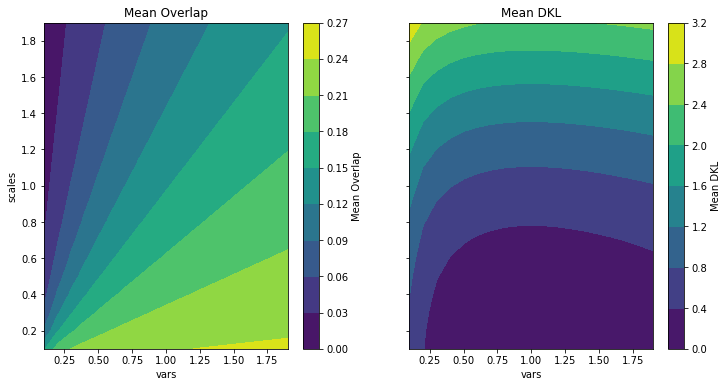

In [7]:
vars_grid, scales_grid = np.meshgrid(vars, scales)

f, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)
h1 = ax[0].contourf(vars_grid,scales_grid,np.asarray(results["mean_overlap"]).reshape((n_scales,n_vars)))
plt.colorbar(h1,ax=ax[0], label='Mean Overlap')
h2 = ax[1].contourf(vars_grid,scales_grid,np.asarray(results["mean_l_dkl"]).reshape((n_scales,n_vars)))
plt.colorbar(h2,ax=ax[1], label='Mean DKL')
ax[0].set_xlabel("vars")
ax[1].set_xlabel("vars")
ax[0].set_ylabel("scales")
ax[0].set_title("Mean Overlap")
ax[1].set_title("Mean DKL")
plt.show()

In the upper figures we see the *scales* and *vars* factor.
*scales* is the variance of the Gaussian, from which the mean values are sampled.
*vars* is the variance of the corresponding means.
Therefore, we sample the parameters from a *Bayesian Mixture of Gaussian* (w/o actually sampling from it).

For the *Mean Overlap* plot, we observe expected behaviour:
We observe that the overlap reduces for increasing *scales*, because each of the sampled Gaussian is further away from the other.
For increasing *vars* the overlap increases.

For the *Mean DKL* plot, we observe behaviour similar to the *DKL vs. var* plot:
We observe a DKL optimum around *vars*=1.0.
The DKL increases with increasing *scales*, because the samples are further away from the prio mean (s.t. 0).

In [8]:
def plot_results(results, do_show = True, figsize=(12, 12)):
    cmap = matplotlib.cm.get_cmap('jet')
    # Cast to numpy
    for key in results:
        results[key] = np.asarray(results[key])

    _, ax = plt.subplots(1,1, figsize=figsize)

    def get_mask(var_idx, scale_idx):
        '''Get masks for constant var and scale'''
        var_mask = np.asarray([var == vars[var_idx] for var in results["var"]], dtype=bool)
        scale_mask = np.asarray([scale == scales[scale_idx] for scale in results["scale"]], dtype=bool)
        return var_mask, scale_mask

    for var_idx in range(n_vars):
        for scale_idx in range(n_scales):
            var_mask, scale_mask = get_mask(var_idx, scale_idx)
            ax.plot(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], c=[.9, .9, .9, .9], zorder=1)
            ax.plot(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], c=[.9, .9, .9, .9], zorder=1)

    # Visualization of all sweeps
    ax.scatter(results["mean_l_dkl"], results["mean_overlap"], c=[31./255.,119./255.,180./255., 1.],label="Samples", zorder=10)

    # Choose var=1 and scale=1
    var_idx = 9
    scale_idx = 9
    print("const. var value: ", vars[var_idx])
    print("const. scale value: ", scales[scale_idx])
    var_mask, scale_mask = get_mask(var_idx, scale_idx)

    # Constant var
    ax.plot(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], 'm', label='const. var')
    val = results["scale"][var_mask]
    rgba = cmap((val - val.min()) / val.max())
    ax.scatter(results["mean_l_dkl"][var_mask], results["mean_overlap"][var_mask], c = rgba, zorder=20)

    # Constant scale
    ax.plot(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], 'c', label='const. scale')
    val = results["var"][scale_mask]
    rgba = cmap((val - val.min()) / val.max())
    ax.scatter(results["mean_l_dkl"][scale_mask], results["mean_overlap"][scale_mask], c = rgba, zorder=20) #, edgecolors = None, linewidths = 5, s = 200

    # Colorbar
    import matplotlib.cm as cm
    m = cm.ScalarMappable(cmap=cm.jet)
    m.set_array(val)
    plt.colorbar(m, label='var and scale values')

    # Standard Gaussian
    np.random.seed(seed=0)
    mean = np.random.normal(loc=0.0, scale=1., size=n)
    _var = np.ones(shape=(n,))
    _mean_overlap, _, _, _mean_l_dkl = losses(mean, _var)
    plt.scatter(_mean_l_dkl, _mean_overlap, marker='o', s=10, linewidths = 10, c='r', label="Gaussian Prior", zorder=30)

    ax.legend()
    ax.set_xlabel("DKL")
    ax.set_ylabel("Overlap")
    if do_show:
        plt.show()
    return ax


const. var value:  1.0
const. scale value:  1.0


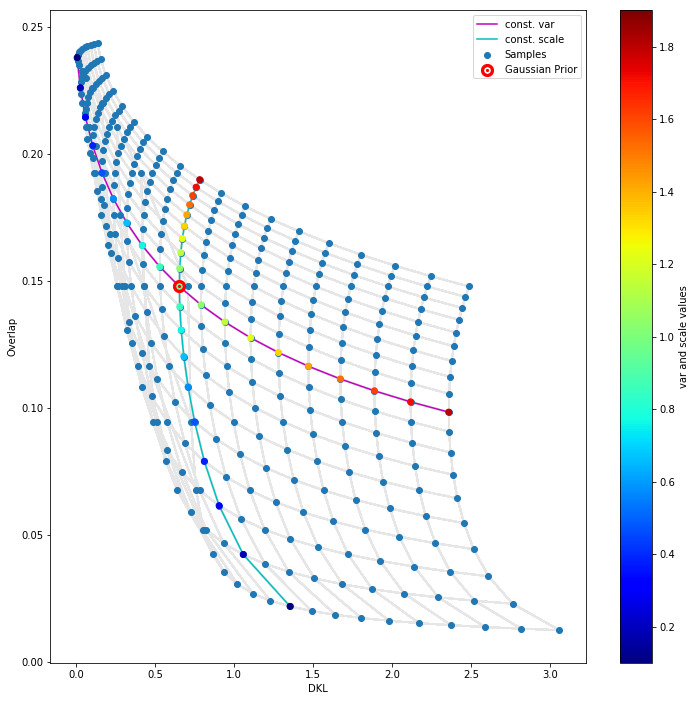

In [9]:
plot_results(results)

Notice that there is no parameter set which describes the whole pareto front. However, there seems to be a flat horizontal curve starting at about (0.4, 0.15) .. (2.5, 0.15), which is in fact just an artefact.

- Go on with: is the final distribution, if sampled from all Gausians, again a Gaussian? Central limit theorem?
- What is the optimal distribution?

# Find optimal distribution

In [10]:
from scipy.optimize import minimize # minimize(f, x0, args=(a, b, c))

def find_best_configuration(n, epoch, mean, var, alpha, n_jobs):
    def objective(current_mean_var, current_idx, mean, var):
        mean[current_idx] = current_mean_var[0]
        var[current_idx] = current_mean_var[1]
        mean_overlap, _, _, mean_l_dkl = losses(mean, var, debug = False, n_jobs=n_jobs, do_parallel=2)
        return alpha * mean_overlap + mean_l_dkl

    results = {"mean_overlap": [], "mean_l_var": [], "mean_l_mean": [], "mean_l_dkl": [], "mean": [], "var": [], "idx": [-1]}
    store_results(results, mean, var)
    results["mean"].append(mean.copy())
    results["var"].append(var.copy())
    for e in range(epoch):
        if np.mod(e, 100) == 0:
            print("Progress: ", e+1, "/", epoch)
        # Optimize the objective
        #current_idx = np.random.randint(0,n) # choose one of the samples randomly
        current_idx = np.mod(e,n) # choose one after another
        mean_var_0 = np.asarray([mean[current_idx], var[current_idx]])
        res = minimize(objective, mean_var_0, args=(current_idx, mean, var), method='Nelder-Mead',
                       tol=None, options = {"maxiter": 2, "disp": False})
        # Copy back
        mean[current_idx] = res.x[0]
        var[current_idx] = res.x[1]

        # store evaluation
        store_results(results, mean, var, debug = False, do_parallel = 2, n_jobs = n_jobs)
        results["mean"].append(mean.copy())
        results["var"].append(var.copy())
        results["idx"].append(current_idx)
    return results

def plot_best_configuration(results):
    f, ax = plt.subplots(2,2, figsize=(12,12), sharex='col')
    sort_order = np.argsort(results["mean"][-1])
    ax[0,0].stem(results["mean"][-1][sort_order])
    ax[1,0].stem(results["var"][-1][sort_order])
    ax[0,1].plot(results["mean_overlap"])
    ax[1,1].plot(results["mean_l_dkl"])
    #ax[0,0].set_title("mean")
    #ax[1,0].set_title("var")
    #ax[0,1].set_title("mean_overlap")
    #ax[1,1].set_title("mean_l_dkl")
    ax[1,0].set_xlabel("Smaple index")
    ax[1,1].set_xlabel("epoch")
    ax[0,0].set_ylabel("Mean value of samples")
    ax[1,0].set_ylabel("Variance value of samples")
    ax[0,1].set_ylabel("Mean overlapp")
    ax[1,1].set_ylabel("Mean DKL")
    plt.tight_layout()
    plt.show()

In [11]:
#n = 11 # some uneven number so that one value is centred at 0.0
epoch = n * 20
mean_0 = np.linspace(-1, 1, n, True)
var_0 = .5 * np.ones(shape=(n,))
alpha = 1.
n_jobs = 16
results_configuration = find_best_configuration(n, epoch, mean_0, var_0, alpha, n_jobs)


Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420


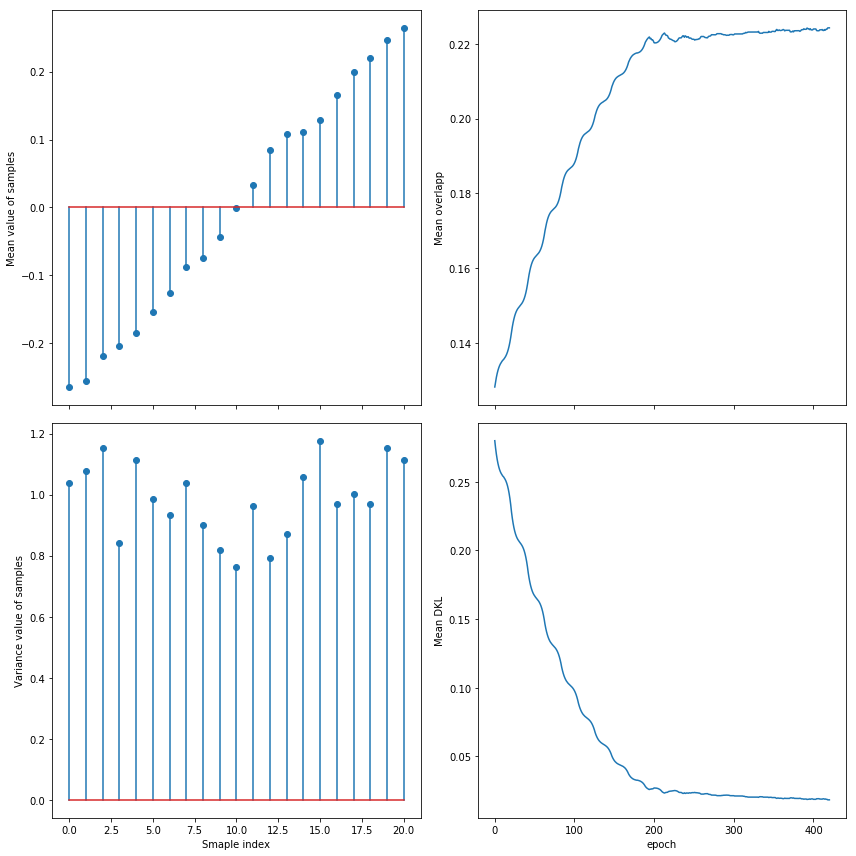

In [12]:
plot_best_configuration(results_configuration)

In [13]:
# Sweep through alpha

results_configurations = {"alpha": [], "results_configuration": []}
alphas = [0.1, 0.5, 1.0, 2.0, 5.0, 10., 20., 30.]
for alpha in alphas:
    print("alpha: ", alpha)
    #n = 11 # same uneven number so that one value is centred at 0.0
    epoch = n * 20
    mean_0 = np.linspace(-1, 1, n, True)
    var_0 = .5 * np.ones(shape=(n,))
    n_jobs = 16
    results_configuration = find_best_configuration(n, epoch, mean_0, var_0, alpha, n_jobs)
    results_configurations["alpha"].append(alpha)
    results_configurations["results_configuration"].append(results_configuration)
    

alpha:  0.1
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  0.5
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  1.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  2.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  5.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  10.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  20.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420
alpha:  30.0
Progress:  1 / 420
Progress:  101 / 420
Progress:  201 / 420
Progress:  301 / 420
Progress:  401 / 420


In [14]:
final_mean_l_dkl = []
final_mean_overlap = []
for results_configuration in results_configurations["results_configuration"]:
    final_mean_l_dkl.append(results_configuration["mean_l_dkl"][-1])
    final_mean_overlap.append(results_configuration["mean_overlap"][-1])


0.01837018759756335

const. var value:  1.0
const. scale value:  1.0


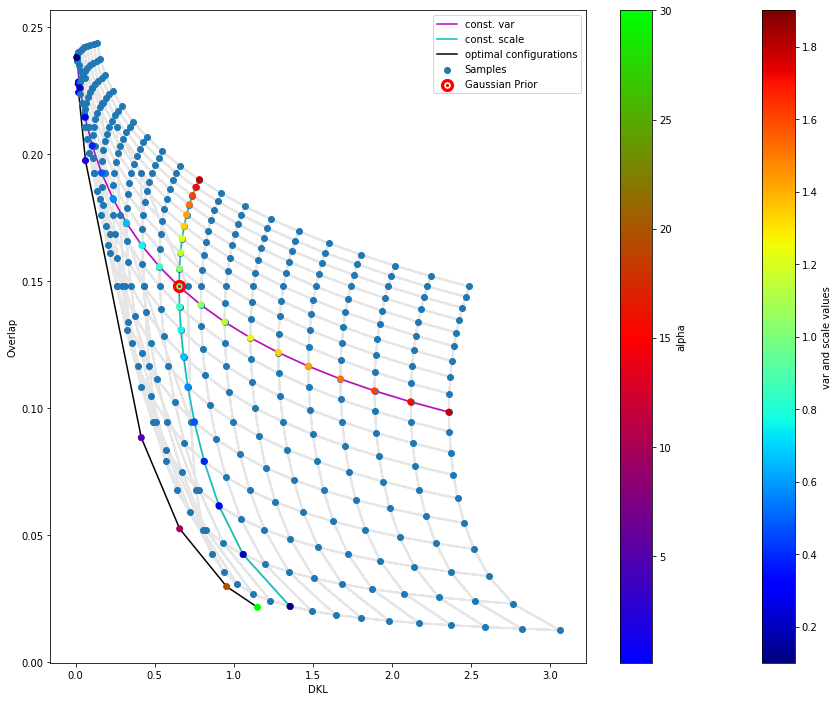

In [16]:
ax = plot_results(results, do_show = False, figsize=(15, 12))
cmap = matplotlib.cm.get_cmap('brg')
val = np.asarray(alphas)
rgba = cmap((val - val.min()) / val.max())
ax.plot(final_mean_l_dkl, final_mean_overlap, c=[0.,0.,0.,1.], zorder=1, label='optimal configurations')
ax.scatter(final_mean_l_dkl, final_mean_overlap, c=rgba, zorder=2)
m = cm.ScalarMappable(cmap=cm.brg)
m.set_array(alphas)
plt.colorbar(m, label='alpha')
plt.legend()
plt.show()


In [18]:
n = 101 # some uneven number so that one value is centred at 0.0
epoch = n * 200
mean_0 = np.linspace(-1, 1, n, True)
var_0 = .5 * np.ones(shape=(n,))
alpha = 20.
n_jobs = 16
results_configuration = find_best_configuration(n, epoch, mean_0, var_0, alpha, n_jobs)


Progress:  1 / 20200
Progress:  101 / 20200
Progress:  201 / 20200
Progress:  301 / 20200
Progress:  401 / 20200
Progress:  501 / 20200
Progress:  601 / 20200
Progress:  701 / 20200
Progress:  801 / 20200
Progress:  901 / 20200
Progress:  1001 / 20200
Progress:  1101 / 20200
Progress:  1201 / 20200
Progress:  1301 / 20200
Progress:  1401 / 20200
Progress:  1501 / 20200
Progress:  1601 / 20200
Progress:  1701 / 20200
Progress:  1801 / 20200
Progress:  1901 / 20200
Progress:  2001 / 20200
Progress:  2101 / 20200
Progress:  2201 / 20200
Progress:  2301 / 20200
Progress:  2401 / 20200
Progress:  2501 / 20200
Progress:  2601 / 20200
Progress:  2701 / 20200
Progress:  2801 / 20200
Progress:  2901 / 20200
Progress:  3001 / 20200
Progress:  3101 / 20200
Progress:  3201 / 20200
Progress:  3301 / 20200
Progress:  3401 / 20200
Progress:  3501 / 20200
Progress:  3601 / 20200
Progress:  3701 / 20200
Progress:  3801 / 20200
Progress:  3901 / 20200
Progress:  4001 / 20200
Progress:  4101 / 20200
Prog

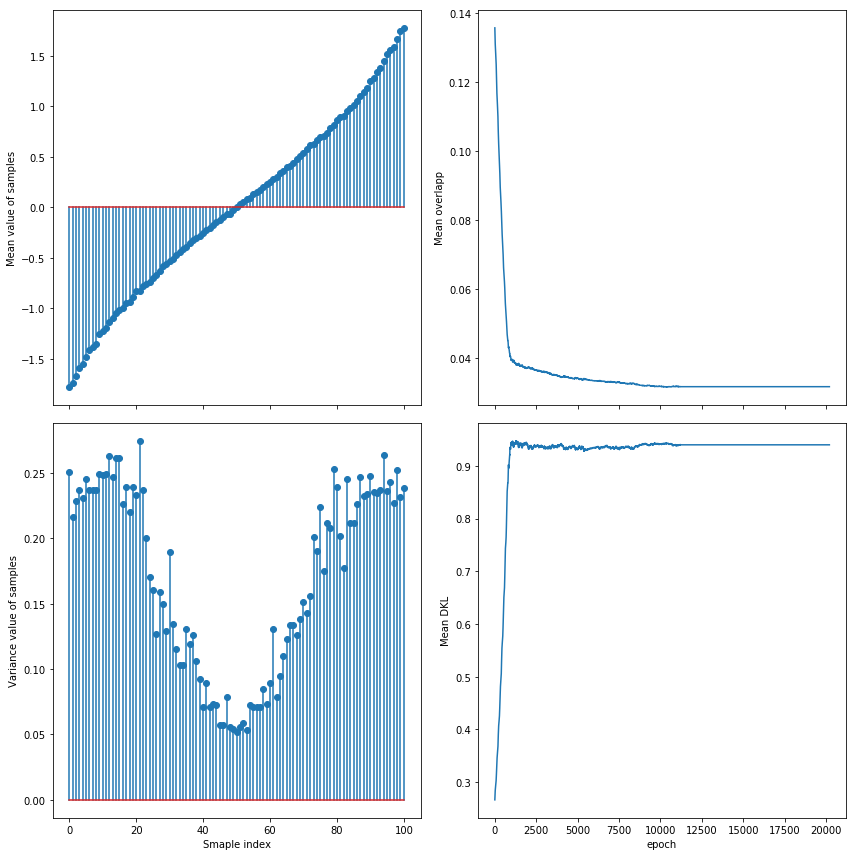

In [22]:
import pickle
import bz2
fname = models/optimal_latent_distribution_n101_example.pkl
if True: # load results from disk    
    sfile = bz2.BZ2File(fname, 'r')
    results_configuration = pickle.load( sfile )
else:
    sfile = bz2.BZ2File(fname, 'w')
    pickle.dump( results_configuration, sfile )
plot_best_configuration(results_configuration1)